# Analyzing seasonality w/ Fourier Transforms

Analyze 911 phone call data from Montgomery County, PA. We’re looking to answer whether there are higher or lower levels of 911 calls during:
- Certain hours of the day?
- Certain days of the week?
- Certain months of the year?

In [1]:
from scipy import fft
from scipy import signal as sig
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

import warnings
warnings.simplefilter('ignore')

sns.set(rc={'figure.figsize':(12,6)})

## Preparing Data

In [186]:
df = pd.read_csv('../data/911.csv')
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [187]:
# Prepare Data
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df['timestamp_trunc'] = df['timeStamp'].dt.floor('H')
df['N'] = 1

In [23]:
# Count Calls
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]
counts.head()

,N
timestamp_trunc,
2015-12-10 14:00:00,1
2015-12-10 15:00:00,1
2015-12-10 16:00:00,6
2015-12-10 17:00:00,16
2015-12-10 18:00:00,26


In [5]:
# Create time & signal, filling in missing hours with 0 calls
time = pd.date_range(start=counts.index[0], end=counts.index[-1], freq='H')
signal = pd.Series(index=time, data=counts['N']).fillna(0)

In [6]:
signal_ = signal-signal.mean()

<AxesSubplot:>

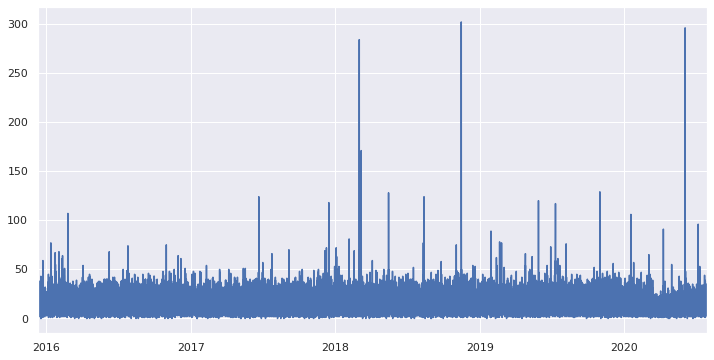

In [7]:
signal.plot()

<AxesSubplot:>

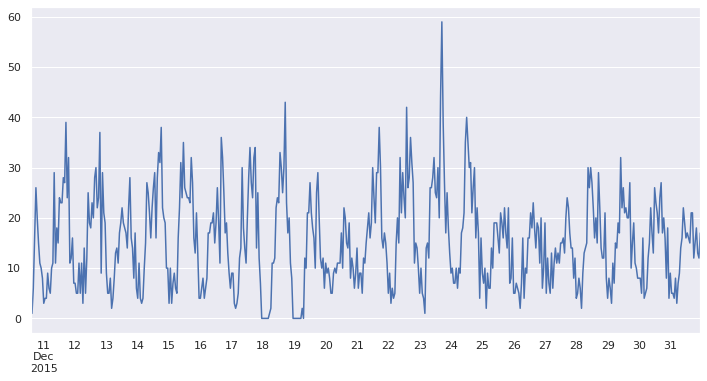

In [8]:
signal.loc['2015'].plot()

## Fourier Transform

In [13]:
# Use FFT from scipy
fft_out = fft.fft(np.array(signal_))
fft_out = pd.Series(fft_out, index=signal_.index)
power = np.abs(fft_out)

# Compute discrete fourier transform sample frequencies
freq = fft.fftfreq(len(signal_))

In [14]:
# Create and Apply a mask
mask = freq >= 0
freq = freq[mask]
power = power[mask]

In [15]:
# Find peaks
peaks = sig.find_peaks(power, prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]

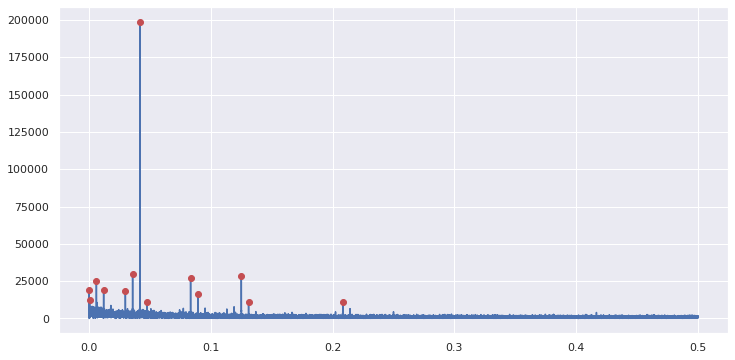

In [16]:
# Plot results
plt.plot(freq, power, peak_freq, peak_power, 'ro')

In [17]:
output = pd.DataFrame(
    index=peaks,
    data={
        'freq (1/hour)': peak_freq,
        'amplitude': np.array(peak_power),
        'period (days)': 1 / (peak_freq*24),
        'fft': np.array(fft_out[peaks])
    }
).sort_values('amplitude', ascending=False)

output

,freq (1/hour),amplitude,period (days),fft
1693,0.041665,198675.270449,1.000049,193308.035619+45867.924014j
1451,0.035709,29826.298934,1.166839,29053.5260230+6745.4231710j
5079,0.124994,28257.892417,0.333350,8585.428799-026922.0893730j
3386,0.083329,27023.632734,0.500025,-25121.3334240-9959.6853920j
242,0.005956,25181.938810,6.996212,25132.2219670+1581.6008310j
484,0.011911,18985.889403,3.498106,-16064.836794-10118.548078j
1,0.000025,18942.026939,1693.083333,-17232.7946750+7863.2799940j
1209,0.029753,18102.491214,1.400400,-17575.4370880+4336.3809000j
3628,0.089285,16368.340383,0.466671,10035.185074-12931.265499j
14,0.000345,12143.089843,120.934524,-6949.1832720+9958.0863010j


## Inverse Fourier Transform

In [18]:
filtered_fft_out = np.array([f if i in output.index else 0 for i, f in enumerate(fft_out)])

In [19]:
filtered_sig = pd.Series(fft.ifft(filtered_fft_out), index=signal.index)

<AxesSubplot:>

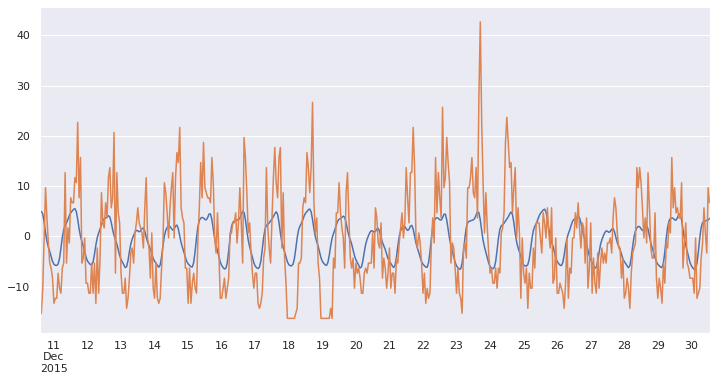

In [21]:
filtered_sig.iloc[:24*20].plot()
signal_.iloc[:24*20].plot()

# Linear regression w/ Fourier terms

In [181]:
# Count calls per hour
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]
counts_dict = counts['N'].to_dict()

In [190]:
# Create a new DF with time & signal, filling in missing hours with 0 calls
data = pd.DataFrame()
data['time'] = pd.date_range(min(counts.index), max(counts.index), freq = 'H')
data['time_sec'] = (data.time - min(data.time)).dt.total_seconds()
data['signal'] = data.time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

In [196]:
data.head()

,time,time_sec,signal
0,2015-12-10 14:00:00,0.0,1
1,2015-12-10 15:00:00,3600.0,1
2,2015-12-10 16:00:00,7200.0,6
3,2015-12-10 17:00:00,10800.0,16
4,2015-12-10 18:00:00,14400.0,26


### Scikit-Learn Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression

In [197]:
# Training data
X = data[['time_sec']]
y = data[['signal']]

In [198]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [199]:
data['pred_signal_linreg'] = model.predict(X)
data['residuals'] = data['signal'] - data['pred_signal_linreg']

In [200]:
data.head()

,time,time_sec,signal,pred_signal_linreg,residuals
0,2015-12-10 14:00:00,0.0,1,16.491164,-15.491164
1,2015-12-10 15:00:00,3600.0,1,16.491156,-15.491156
2,2015-12-10 16:00:00,7200.0,6,16.491148,-10.491148
3,2015-12-10 17:00:00,10800.0,16,16.491140,-0.491140
4,2015-12-10 18:00:00,14400.0,26,16.491132,9.508868


In [201]:
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

Slope: -2.21e-09, Intercept: 16.49
R-squared: 7.75e-05


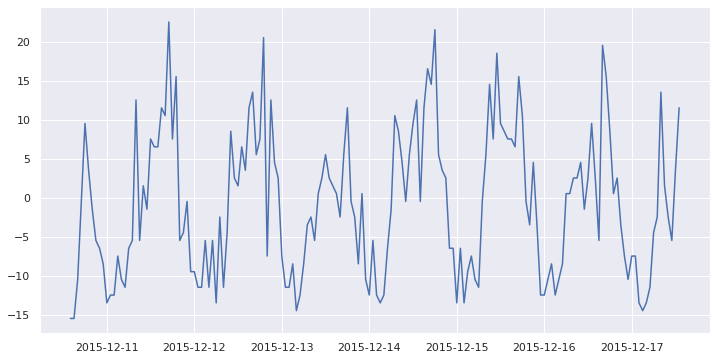

In [205]:
time = data.time
residuals = data.residuals
N=24*7
plt.plot(time[:N], residuals[:N])

### Fourier Transform of the Residuals

In [107]:
def find_fourier_peaks(signal):
    
    fft_out = pd.Series(
        fft.fft(np.array(signal)),
        index=signal.index)
    
    power = np.abs(fft_out)
    freq = fft.fftfreq(len(signal))
    
    # Create and Apply a mask
    mask = freq >= 0
    freq = freq[mask]
    power = power[mask]
    
    # Find peaks
    peaks = sig.find_peaks(power, prominence=10**4)[0]
    peak_freq =  freq[peaks]
    peak_power = power[peaks]
    
    # Create Dataframe
    output = pd.DataFrame(
        index=peaks,
        data={
            'freq (1/hour)': peak_freq,
            'amplitude': np.array(peak_power),
            'period (days)': 1 / (peak_freq*24),
            'fft': np.array(fft_out[peaks])
        }
    ).sort_values('amplitude', ascending=False)
    
    # Plot results
    fig, ax = plt.plot(freq, power, peak_freq, peak_power, 'ro')
    
    return output, ax

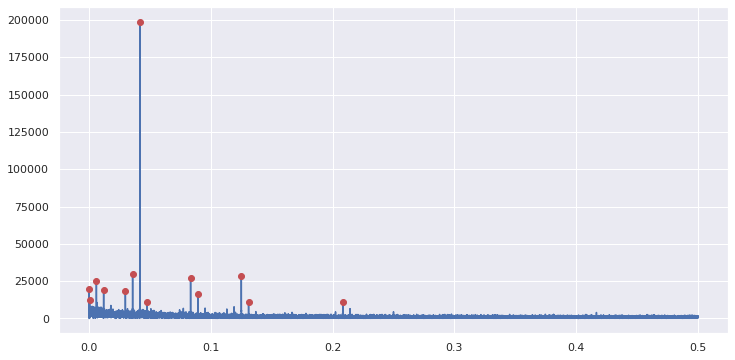

In [206]:
output, ax = find_fourier_peaks(residuals)

In [227]:
filtered_fft = np.zeros(len(residuals), dtype=complex)

In [228]:
filtered_fft[output.index] = output.fft

In [243]:
filtered_residuals = fft.ifft(filtered_fft)

(array([16780., 16781., 16782., 16783., 16784.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

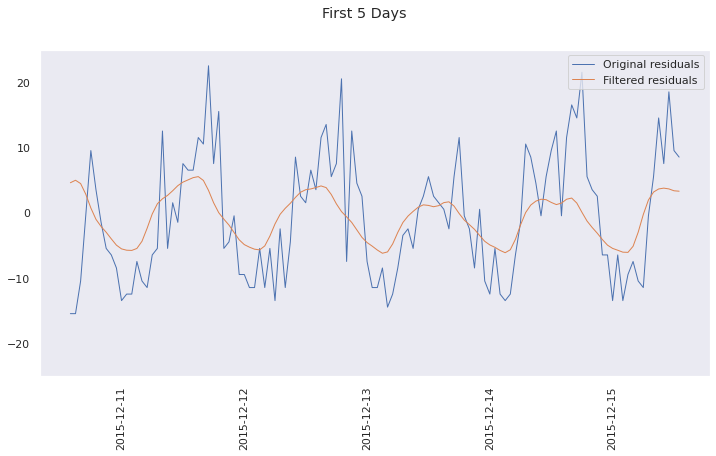

In [244]:
N = 24 * 5
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

### Fourier Terms

In [245]:
from cmath import phase

In [257]:
fourier_terms = output.drop('period (days)', axis=1)
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms['label'] = list(map(lambda n: 'FT_{}'.format(n), range(1, len(fourier_terms)+1)))
fourier_terms = fourier_terms.set_index('label', drop=True)

In [263]:
fourier_terms_dict = fourier_terms.to_dict('index')

In [272]:
def compute_fourier_terms(data, fourier_terms_dict):
    
    for key in fourier_terms_dict.keys():
        a = fourier_terms_dict[key]['amplitude']
        w = 2 * math.pi * (fourier_terms_dict[key]['freq (1/hour)'] / 3600)
        p = fourier_terms_dict[key]['phase']
        
        data[key] = data['time_sec'].apply(lambda t: a*math.cos(w*t + p))
        
    data['FT_ALL'] = 0
    for column in list(fourier_terms.index):
        data['FT_ALL'] = data['FT_ALL'] + data[column]
        
    return data

In [273]:
data = compute_fourier_terms(data, fourier_terms_dict)

In [275]:
data.head()

,time,time_sec,signal,pred_signal_linreg,residuals,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,FT_9,FT_10,FT_11,FT_12,FT_13,FT_ALL
0,2015-12-10 14:00:00,0.0,1,16.491164,-15.491164,193307.873683,29053.364087,8585.266863,-25121.495360,25132.060031,-17232.956611,-16064.998730,-17575.599024,10035.023138,-6949.345208,1710.701945,-9583.836580,10716.931242,186012.989477
1,2015-12-10 15:00:00,3600.0,1,16.491156,-15.491156,174850.472550,26824.050019,25106.714678,-16776.858637,25054.972563,-17234.496166,-15263.783842,-18075.645891,15376.414932,-6971.210072,-1650.577059,2425.957273,7768.415520,201434.425868
2,2015-12-10 16:00:00,7200.0,6,16.491148,-10.491148,144478.466917,23250.061604,26922.362087,-3937.308545,24942.805499,-17236.035309,-14377.115269,-17945.806983,16004.232458,-6993.042266,-4865.187883,10839.906417,-148.992683,180934.346044
3,2015-12-10 17:00:00,10800.0,16,16.491140,-0.491140,104261.456195,18510.560844,12968.726721,9957.138725,24795.715886,-17237.574040,-13409.956989,-17190.606823,11726.020936,-7014.841688,-7647.484295,3186.540378,-7971.101063,114934.594786
4,2015-12-10 18:00:00,14400.0,26,16.491132,9.508868,56939.894956,12843.136214,-8581.103892,21183.835318,24613.909665,-17239.112359,-12367.723601,-15836.362030,3853.247822,-7036.608235,-9750.234971,-9190.035127,-10694.673708,28738.170052


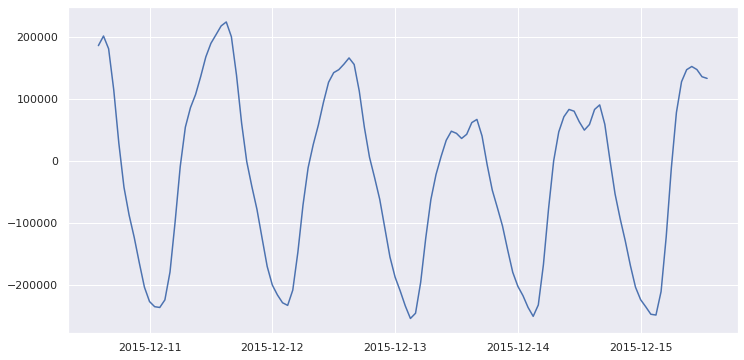

In [279]:
plt.plot(data['time'][:24*5], data['FT_ALL'][:24*5])

In [299]:
X = data[['time_sec', 'FT_ALL']]
y = data['signal']

In [294]:
data = data.set_index('time')

In [302]:
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
y_pred = pd.Series(y_pred, index=time)

<AxesSubplot:xlabel='time'>

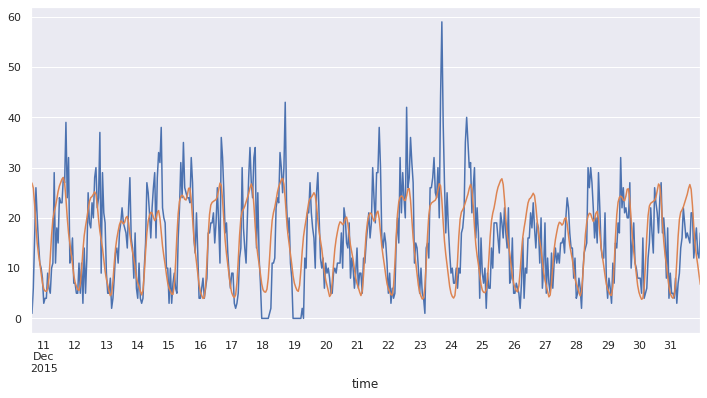

In [306]:
data.signal.loc['2015'].plot()
y_pred.loc['2015'].plot()

In [307]:
model.score(X, y)

0.4776653053720067